In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import earthpy as et
from PIL import Image
import geopandas as gpd
from rasterio.plot import show
import re
from IPython.display import clear_output
import requests
import json
import math
import fiona

In [2]:
# get the relative path of the current project that this notebook is in
project_path = os.path.abspath(os.path.join("readfiles.ipynb", os.pardir, os.pardir))
print("Found project in: ", project_path)
data_path = os.path.join(project_path, "Data")

external_data_path = "/media/becode/DiskSpaceInvader/3DHouseData"


def search_files(fpath: str, file_type: str, func):
    total_files = 0
    # Walk through the folder containing the data, and check if the files match the file type
    # If so; open that file, and print how many there were found
    for root, dirs, files in os.walk(fpath):
        for name in files:
            if name.endswith(file_type):
                func(root + "/" + name)
                total_files += 1
    print(f"Found {total_files} {file_type} files.")
    return


all_tifs = []
search_files(external_data_path, ".tif", all_tifs.append)
print(len(all_tifs))

Found project in:  /home/becode/Projects/3D-House-Project
Found 88150 .tif files.
88150


In [3]:
def filter_list(lst:[str], txt_pattern:str) -> [str]:
    filtered = []
    for txt in lst:
        if re.search(txt_pattern, txt):
            filtered.append(txt)
    return filtered

small_tifs = filter_list(all_tifs, "_\d_\d_\d_\d.tif")
print(len(small_tifs))

88064


In [6]:
def make_dict_panda(lst:[str]):
    # just a way of presenting progress in creating the panda to the user
    # divides the length of the input list into percentages
    lst_len = len(lst)
    onepercent = lst_len // 100
    i = 0
    percent_finished = 0
    
    d = []
    for fpath in lst:
        i += 1
        tif = rio.open(fpath)
        d.append(
            {
                'file_path': fpath,
                'id': fpath[-17:-4],    #store the substring of the filename that is relevant.
                                        # ex. DSM(k19_0_1_2_3_0).tif only what's inside the brackets is stored
                'left_bound': tif.bounds.left,
                'bottom_bound': tif.bounds.bottom,
                'right_bound': tif.bounds.right,
                'top_bound': tif.bounds.top,
                'width_bound': tif.width,
                'height_bound': tif.height
            }
        )     
        tif.close()
        # a more visually pleasing way of showing that this is working
        if i%onepercent == 0:
            percent_finished += 1
            print(f"{percent_finished}% | file {i} of {lst_len}")
            clear_output(wait=True)
    df = pd.DataFrame(d)
    return df

dict_panda = make_dict_panda(small_tifs)

# Save the DataFrame to a csv file so it doesn't have to be constructed every time.
dict_panda.to_csv(os.path.join(project_path, "overviewdataframe.csv"), encoding='utf-8', index=False)
dict_panda.info

100% | file 88000 of 88064


In [21]:
def address_lookup(addr:str, debug=False):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={addr}&c=1",)
    ret_dict = {}
    for k,v in req.json()["LocationResult"][0].items():
        if debug: print(f"{k}: {v}")
        ret_dict[k] = [v]
    return ret_dict

beacon = address_lookup("Sint-Pietersvliet 17", True)
beacon.keys()

Municipality: Antwerpen
Zipcode: 2000
Thoroughfarename: Sint-Pietersvliet
Housenumber: 17
ID: 1847198
FormattedAddress: Sint-Pietersvliet 17, 2000 Antwerpen
Location: {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}
LocationType: crab_huisnummer_afgeleidVanPerceelGrb
BoundingBox: {'LowerLeft': {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}, 'UpperRight': {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}}


dict_keys(['Municipality', 'Zipcode', 'Thoroughfarename', 'Housenumber', 'ID', 'FormattedAddress', 'Location', 'LocationType', 'BoundingBox'])

In [57]:
margin = 10

def find_tiles(tile_panda, address_dict, debug=False):
    results = []
    bbox = address_dict['BoundingBox'][0]
    lower_left, upper_right = bbox['LowerLeft'], bbox['UpperRight']
    left, bottom = math.floor(lower_left['X_Lambert72']), math.floor(lower_left['Y_Lambert72'])
    right, top = math.ceil(upper_right['X_Lambert72']), math.ceil(upper_right['Y_Lambert72'])
    left -= margin
    bottom -= margin
    right += margin
    top += margin
    if debug: print(bbox, left, bottom, right, top)
    for row in tile_panda.itertuples():
        #if debug: print(row)
        if row.left_bound < left < row.right_bound and row.bottom_bound < bottom < row.top_bound:
            if debug: print(f"Found LowerLeft {lower_left}")
            if row.file_path not in results:
                results.append(row.file_path)
        if row.left_bound < right < row.right_bound and row.bottom_bound < top < row.top_bound:
            if debug: print(f"Found UpperRight {upper_right}")
            if row.file_path not in results:
                results.append(row.file_path)
    return (results, (left, bottom, right, top))
        
        
        
beacontifs = find_tiles(dict_panda, beacon, True)

{'LowerLeft': {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}, 'UpperRight': {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}} 152262 212874 152283 212895
Found LowerLeft {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}
Found UpperRight {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}
Found LowerLeft {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}
Found UpperRight {'Lat_WGS84': 51.22589893259436, 'Lon_WGS84': 4.40129084141427, 'X_Lambert72': 152272.68, 'Y_Lambert72': 212884.98}


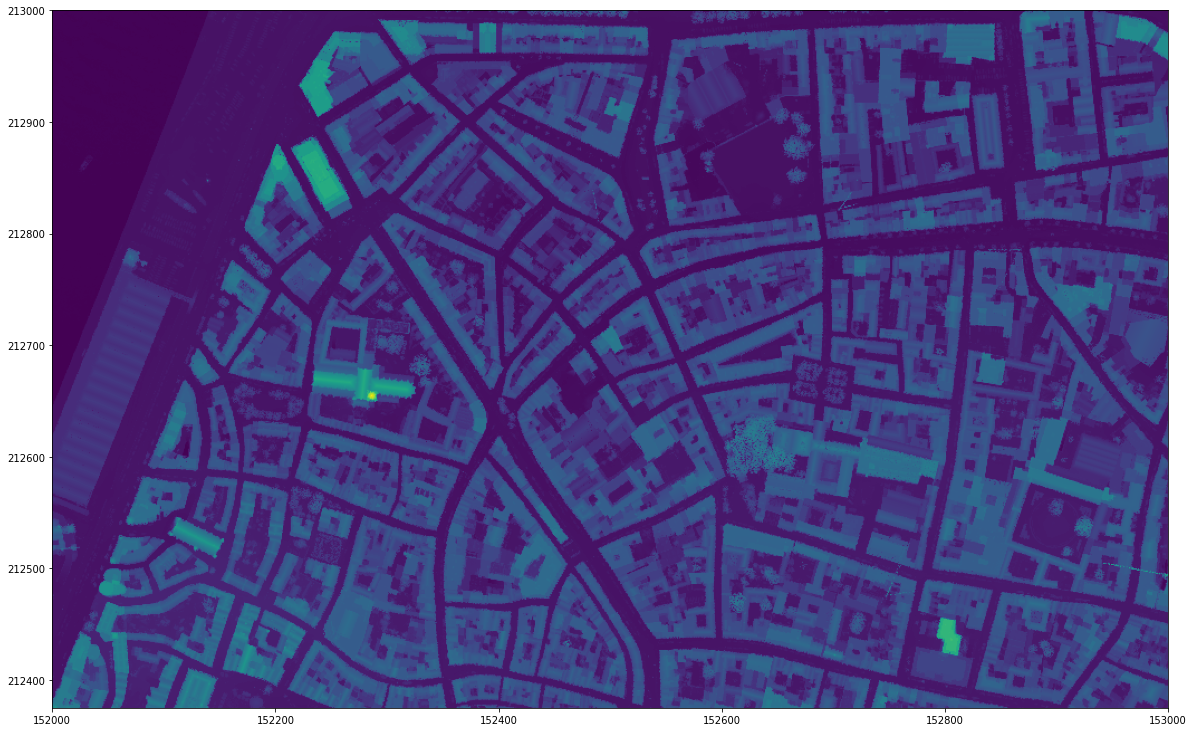

(['/media/becode/DiskSpaceInvader/3DHouseData/DHMVIIDTMRAS1m_k15/GeoTIFF/DHMVIIDTMRAS1m_k15_1_2_1_1_0.tif', '/media/becode/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15_1_2_1_1_0.tif'], (152262, 212874, 152283, 212895))


In [58]:
fig, ax = plt.subplots(1, figsize=(20, 20))
for tif in beacontifs[0]:
    im = rio.open(tif)
    show(im, ax=ax)
    
plt.show()
print(beacontifs)
    

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

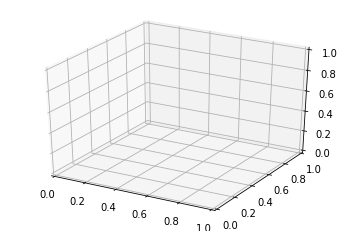

In [99]:
l = beacontifs[1][0]
b = beacontifs[1][1]
r = beacontifs[1][2]
t = beacontifs[1][3]
w = r-l
h = t-b

with rio.open(beacontifs[0][0]) as dtm: 
    with rio.open(beacontifs[0][1]) as dsm:
        terrain_array = dtm.read()
        surface_array = dsm.read()
        chm_array = surface_array - terrain_array
        fig = plt.figure()
        ax.set_aspect('auto')
        ax = fig.add_subplot(projection='3d')
        show(chm_array)

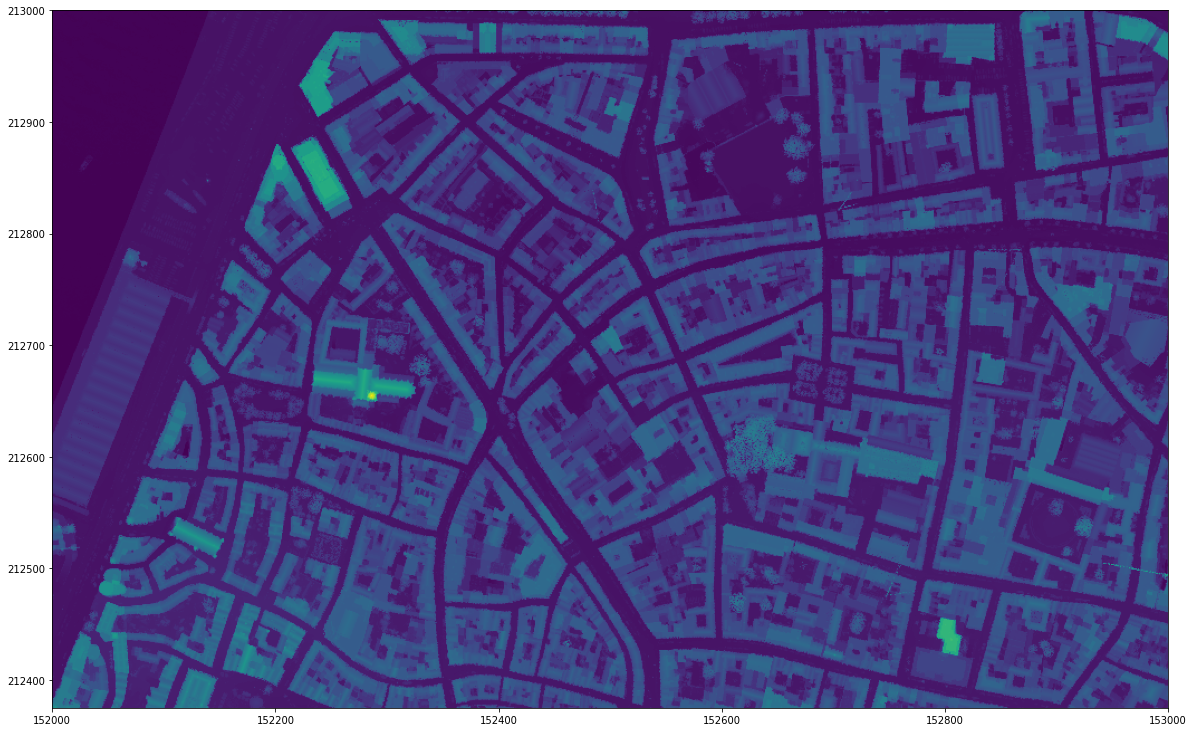

In [56]:
k15shp = "/media/becode/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/DHMVII_vdc_k15/DHMVII_vdc_k15.shp"
fig, ax = plt.subplots(1, figsize=(20, 20))
with fiona.open(k15shp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    with rio.open('/media/becode/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15_1_2_1_1_0.tif') as src:
        out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
            dest.write(out_image)
            
show(rio.open("RGB.byte.masked.tif"))